<a href="https://colab.research.google.com/github/nishika26/Audio_signal_seperation_with_UX_Net/blob/main/Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import librosa
import numpy as np

def load_audio_file(file_path, sr=None):
    """
    Load an audio file using librosa.

    Parameters:
        file_path (str): Path to the audio file.
        sr (int, optional): Target sampling rate. If None, uses the original sampling rate.

    Returns:
        audio_data (np.ndarray): The audio waveform.
        sampling_rate (int): The sampling rate of the audio.
    """
    audio_data, sampling_rate = librosa.load(file_path, sr=sr)
    return audio_data, sampling_rate

# Example usage:
file_path = 'wsj0.wav'
audio_data, sr = load_audio_file(file_path)

# Optionally, resample the audio if needed:
target_sr = 8000  # Replace with your desired sampling rate
if sr != target_sr:
    audio = librosa.resample(audio_data, orig_sr=sr, target_sr=target_sr)
    sr = target_sr

In [ ]:
import tensorflow as tf

def convert_to_tensor(data):
 tensor_data = tf.convert_to_tensor(data,dtype=tf.float32)
 return tensor_data

tensor_audio=convert_to_tensor(audio_data)
tensor_audio

<tf.Tensor: shape=(60640,), dtype=float32, numpy=
array([-1.6954324e-04, -3.3908651e-05, -3.3908651e-05, ...,
        1.0545590e-02,  7.9685329e-03,  1.1189855e-02], dtype=float32)>

In [ ]:
import soundfile as sf

def normalize_audio(data):
  target_peak_amplitude = 1
  current_peak_amplitude = max(abs(data))
  if current_peak_amplitude > 0:
        normalization_gain = target_peak_amplitude / current_peak_amplitude
        normalized_audio_data = data * normalization_gain
  else:
       normalized_audio_data = data

  return normalized_audio_data

normalized_audio_data=normalize_audio(audio_data)


output_file_path = 'normalized_audio.wav'
sf.write(output_file_path, normalized_audio_data, sr)
normalized_audio_data

array([-1.6954324e-04, -3.3908651e-05, -3.3908651e-05, ...,
        1.0545590e-02,  7.9685329e-03,  1.1189855e-02], dtype=float32)

In [ ]:
tensor_normalized_audio = convert_to_tensor(normalized_audio_data)
print(tensor_normalized_audio)

tf.Tensor(
[-1.6954324e-04 -3.3908651e-05 -3.3908651e-05 ...  1.0545590e-02
  7.9685329e-03  1.1189855e-02], shape=(60640,), dtype=float32)


In [ ]:
frequency_domain_duration_ms=2

# Converting duration to seconds
frequency_domain_duration_sec = frequency_domain_duration_ms / 1000.0

# Sample rate of the audio signal (changing this to actual sample rate)
sampling_rate = 8000

# Computing the hop size based on overlap percentage (50% overlap as an example)
overlap_percentage = 0.5
hop_size_sec = frequency_domain_duration_sec * (1 - overlap_percentage)

# Converting the hop size to samples
hop_size_samples = int(hop_size_sec * sampling_rate)

# Determining the window size (sum of hop size and samples corresponding to 2 ms in the frequency domain)
window_size_samples = hop_size_samples + int(frequency_domain_duration_sec * sampling_rate)

hop_size=hop_size_samples
window_size=window_size_samples

print("hop_size=",hop_size)
print("window_size=",window_size)

hop_size= 8
window_size= 24


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [ ]:
import scipy.signal
class STFTLayer(layers.Layer):
   def __init__(self,window_size,hop_size,n_basis_signals):
        super(STFTLayer, self).__init__()
        self.window_size = window_size
        self.hop_size = hop_size
        self.n_basis_signals=n_basis_signals


   def call(self, inputs):
        num_samples = len(inputs)
        num_frames = 1 + (num_samples - self.window_size) // self.hop_size

       # Initializing the STFT result
        stft_result = np.zeros((self.n_basis_signals, num_frames), dtype=np.complex)

       # Generating the basis signals (e.g., Fourier basis)
        basis_signals = np.fft.fft(np.eye(self.n_basis_signals, self.window_size))

        for i in range(num_frames):
        # Extracting the current frame
          frame = inputs[i * self.hop_size : i * self.hop_size + self.window_size]

        # Applying the windowing function (Hamming window)
          window = scipy.signal.hamming(self.window_size)
          windowed_frame = frame * window

        # Computing the DFT for the current frame
          dft_result = np.fft.fft(windowed_frame)

        # Project the DFT result onto the basis signals to get STFT representation
          stft_result[:, i] = np.dot(basis_signals, dft_result)
          return stft_result

# Create an instance of the FrameTransformLayer
window_size=24
hop_siz=8
n_basis_signals=128
STFT_layer = STFTLayer(window_size,hop_size,n_basis_signals)
output_STFT = STFT_layer(tensor_normalized_audio)

In [ ]:
tensor_STFT = convert_to_tensor(output_STFT)
tensor_STFT= tf.expand_dims(tensor_STFT, axis=0)
TENSOR_STFT = tf.expand_dims(tensor_STFT, axis=-1)

In [ ]:
output_encoder= tf.nn.relu(TENSOR_STFT)
E=output_encoder

In [ ]:
import numpy as np

def compute_n_fft(n_basis_signals):
    n_fft = 2 ** int(np.ceil(np.log2(n_basis_signals)))
    return n_fft

n_fft=compute_n_fft(128)
n_fft

128

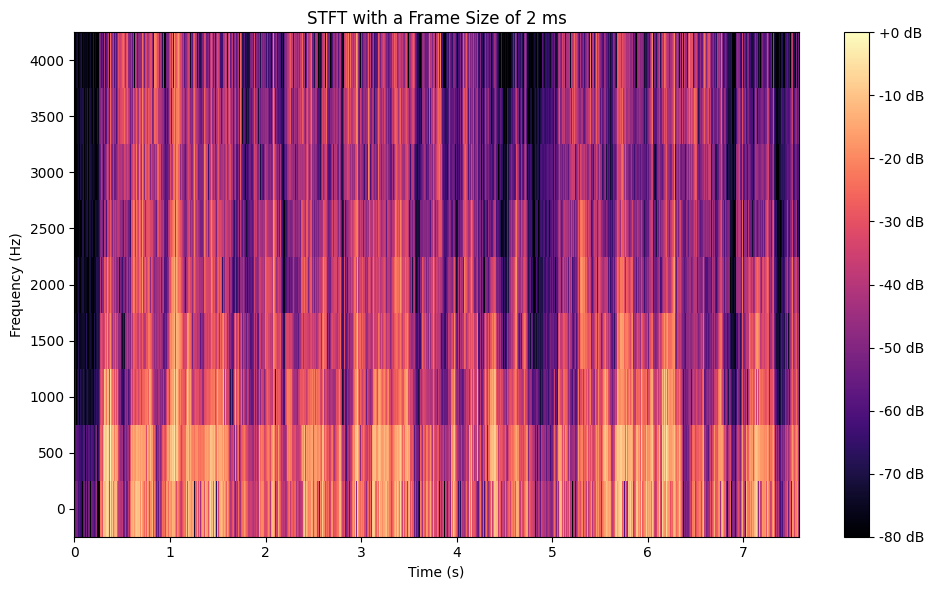

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

n_fft=128
hop_size_samples=8

# Convert the frame size to samples
frame_size_ms = 2  # Frame size in milliseconds
frame_size_sec = frame_size_ms / 1000.0
frame_size_samples = int(frame_size_sec * sr)

# Choose the hop size (50% or 75% of the frame size)
hop_size_samples = int(frame_size_samples * 0.5)  # You can adjust the overlap as needed

# Compute the STFT
stft_result = librosa.stft(normalized_audio_data, n_fft=frame_size_samples, hop_length=hop_size_samples)

# Visualize the STFT
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(stft_result, ref=np.max),
                         sr=sr, hop_length=hop_size_samples, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT with a Frame Size of 2 ms')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()


#MIXER MODULE


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

M = 4

conv_layer = layers.Conv2D(M, kernel_size=(3, 3), padding='same')
batch_norm_layer = layers.BatchNormalization()

prelu_layer = layers.PReLU()


E = output_encoder


x1 = conv_layer(E)
x1 = batch_norm_layer(x1)
EM = prelu_layer(x1)

In [ ]:
C = 2

conv_layer = layers.Conv2D(C, kernel_size=(3, 3), padding='same')
batch_norm_layer = layers.BatchNormalization()

prelu_layer = layers.PReLU()


x2 = conv_layer(EM)
x = batch_norm_layer(x2)
EC = prelu_layer(x2)
EC

<tf.Tensor: shape=(1, 128, 7578, 2), dtype=float32, numpy=
array([[[[0.0000000e+00, 1.1769585e-05],
         [1.2660670e-05, 4.5599802e-05],
         [9.9132585e-06, 1.4007728e-05],
         ...,
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00],
         [3.3401448e-06, 8.3397332e-05],
         [3.6815909e-06, 8.4084546e-05],
         ...,
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]],

        [[1.0887433e-04, 5.1115396e-05],
         [1.4071484e-05, 1.5127214e-04],
         [0.0000000e+00, 3.8148908e-05],
         ...,
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]],

        ...,

        [[0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00],
         ...,
    

#SEPERATION MODULE

In [ ]:
 def wave_u_net(num_initial_filters = 4, num_layers = 5, kernel_size = 9,
                 num_channels = 2, output_filter_size = 1, padding = "same", input_size = 1*128*7578*2):

  # `enc_outputs` stores the downsampled outputs to re-use during upsampling.
  enc_outputs = []

  # `raw_input` is the input to the network
  X = raw_input

  # Down sampling
  for i in range(num_layers):
    X = tf.keras.layers.Conv2D(filters=num_initial_filters + (num_initial_filters * i),
                          kernel_size=kernel_size,strides=1,
                          padding=padding, name="Down_Conv_"+str(i))(X)
    Layer_norm_layer = layers.LayerNormalization()
    X=Layer_norm_layer(name="Down_Conv_Activ_"+str(num_layers))(X)
    X = tf.keras.layers.PReLU(name="Down_Conv_Activ_"+str(num_layers))(X)

    enc_outputs.append(X)

    X = tf.keras.layers.Lambda(lambda x: x[:,::2,:,:], name="Decimate_"+str(i))(X)

    X = tf.keras.layers.Conv2D(filters=num_initial_filters + (num_initial_filters * num_layers),
                          kernel_size=kernel_size,strides=1,
                          padding=padding, name="Down_Conv_"+str(num_layers))(X)
    Layer_norm_layer = layers.LayerNormalization()
    X=Layer_norm_layer(name="Down_Conv_Activ_"+str(i))(X)
    X = tf.keras.layers.PReLU(name="Down_Conv_Activ_"+str(i))(X)

 """ Up sampling

    for i in range(num_layers):

             upscale_factor = (1, 2)
             upsample_lambda = lambda x: tf.image.resize(x, [x.shape[1], x.shape[2] * upscale_factor[1]])
             upsampled_X = upsample_lambda(X)"""







NameError: ignored